In [1]:
import numpy as np
import sep

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib import rcParams
from matplotlib.patches import Ellipse

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
hdul = fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
hdul.info()

Filename: jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, 4A, K, 5A, 9A, D, D, D

In [4]:
data = hdul[1].data

In [5]:
data = np.nan_to_num(data)
data = np.clip(data, 0, None)
data = np.log10(data + 0.01)
data = data - np.min(data)
data = data / np.max(data)

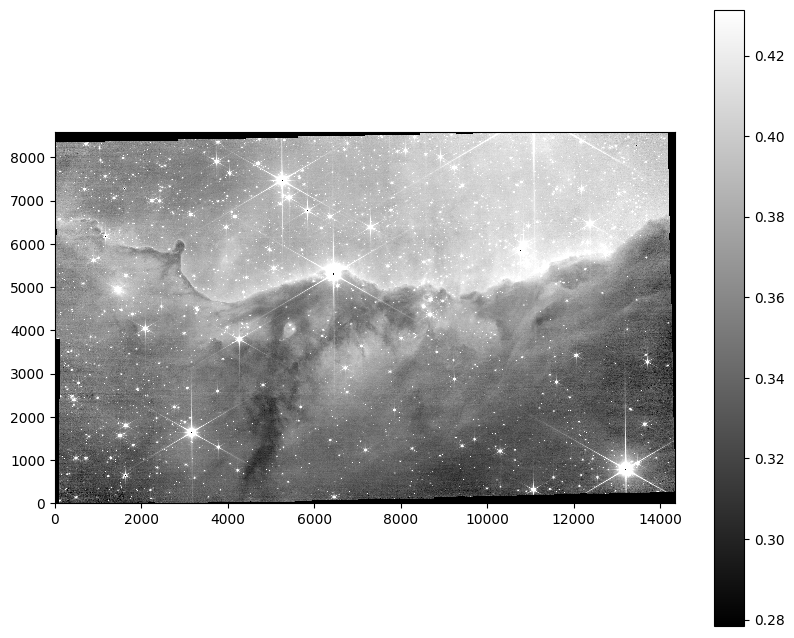

In [6]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("figure1.png", dpi=150)

In [7]:
bkg = sep.Background(data)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.3602258265018463
0.00381804583594203


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

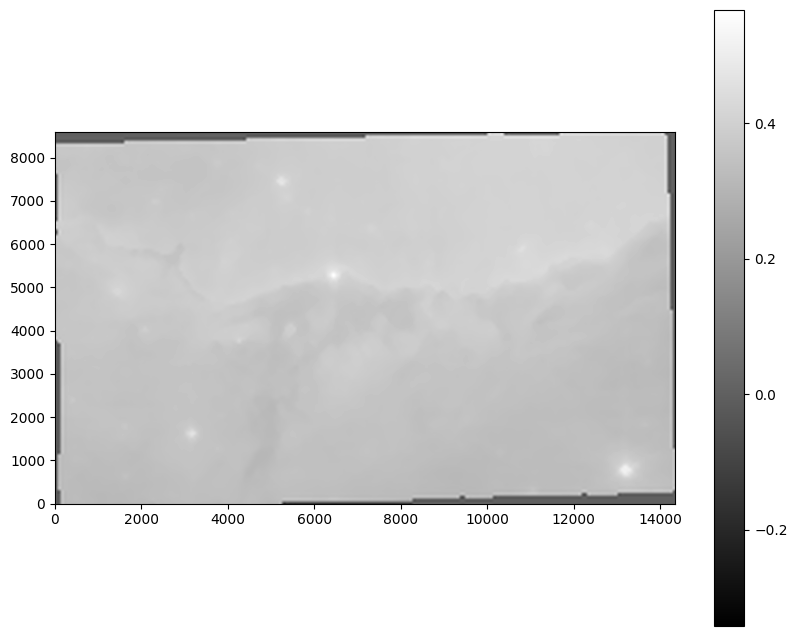

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("figure2.png", dpi=150)

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

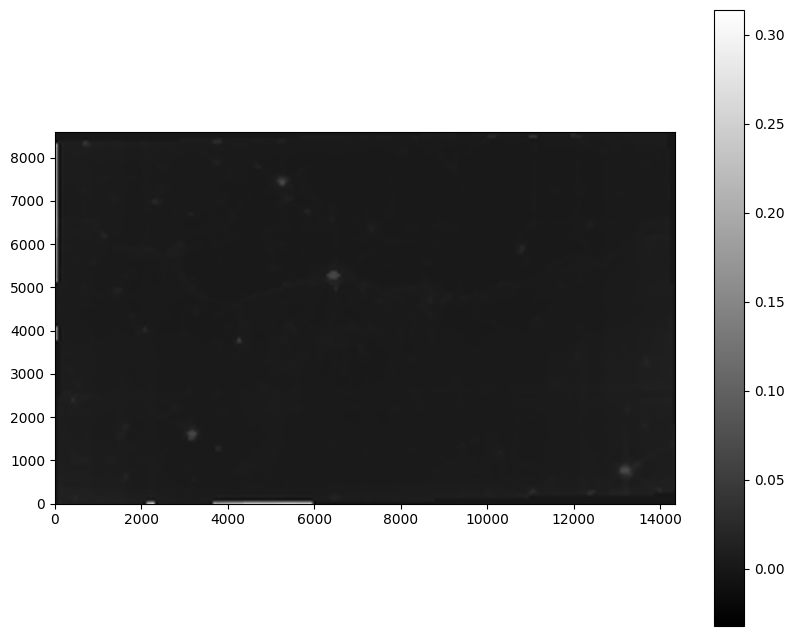

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("figure3.png", dpi=150)

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
sep.set_extract_pixstack(10000000)

In [31]:
objects = sep.extract(data_sub, 100, err=bkg.globalrms)

In [32]:
# how many objects were detected
len(objects)

510

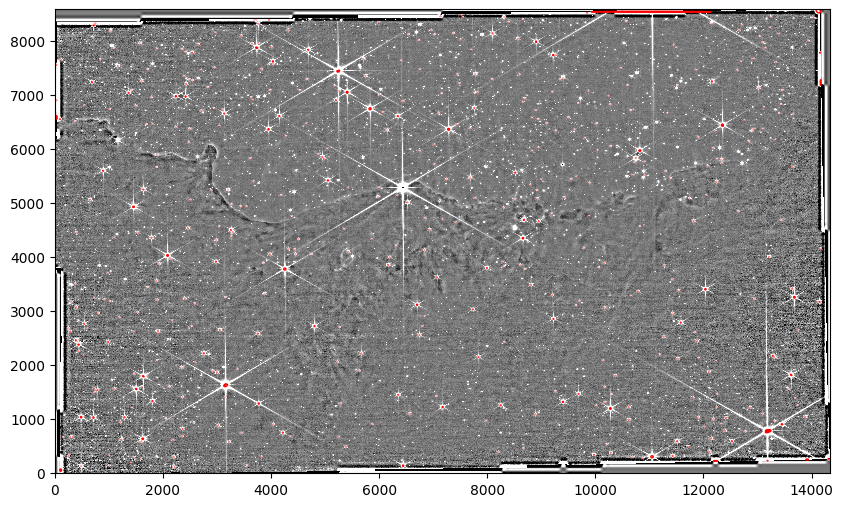

In [33]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("figure4.png", dpi=150)

In [34]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [35]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [36]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 17.027737 +/- 4.126518
object 1: flux = 8.524547 +/- 2.919753
object 2: flux = 8.915197 +/- 2.985901
object 3: flux = 9.602659 +/- 3.098882
object 4: flux = 10.275411 +/- 3.205592
object 5: flux = 0.274317 +/- 0.524147
object 6: flux = 10.052187 +/- 3.170583
object 7: flux = 11.364026 +/- 3.371118
object 8: flux = 11.281210 +/- 3.358813
object 9: flux = 12.452004 +/- 3.528798


Text(0.5, 1.0, 'Histogram of Fluxes')

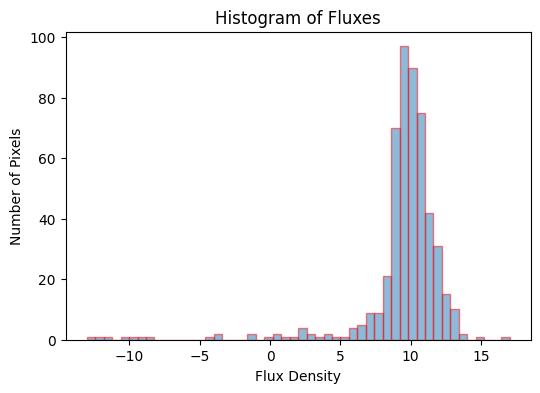

In [37]:
plt.figure(figsize=(6,4))
plt.hist(flux,bins=50,edgecolor="red",alpha=0.5)
plt.xlabel("Flux Density")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Fluxes")

In [ ]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = "./jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "./jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "./jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "./jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "./jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

In [38]:
# read image into standard 2-d numpy array
hdul = fits.open("jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits")
data1 = hdul[0].data
data1 = np.nan_to_num(data1)
data1 = np.clip(data1, 0, None)
data1 = np.log10(data1 + 0.01)
data1 = data1 - np.min(data1)
data1 = data1 / np.max(data1)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits")
data2 = hdul[0].data
data2 = np.nan_to_num(data2)
data2 = np.clip(data2, 0, None)
data2 = np.log10(data2 + 0.01)
data2 = data2 - np.min(data2)
data2 = data2 / np.max(data2)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits")
data3 = hdul[0].data
data3 = np.nan_to_num(data3)
data3 = np.clip(data3, 0, None)
data3 = np.log10(data3 + 0.01)
data3 = data3 - np.min(data3)
data3 = data3 / np.max(data3)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits")
data4 = hdul[0].data
data4 = np.nan_to_num(data4)
data4 = np.clip(data4, 0, None)
data4 = np.log10(data4 + 0.01)
data4 = data4 - np.min(data4)
data4 = data4 / np.max(data4)

hdul = fits.open("jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits")
data5 = hdul[0].data
data5 = np.nan_to_num(data5)
data5 = np.clip(data5, 0, None)
data5 = np.log10(data5 + 0.01)
data5 = data5 - np.min(data5)
data5 = data5 / np.max(data5)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
data6 = hdul[1].data
data6 = np.nan_to_num(data6)
data6 = np.clip(data6, 0, None)
data6 = np.log10(data6 + 0.01)
data6 = data6 - np.min(data6)
data6 = data6 / np.max(data6)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


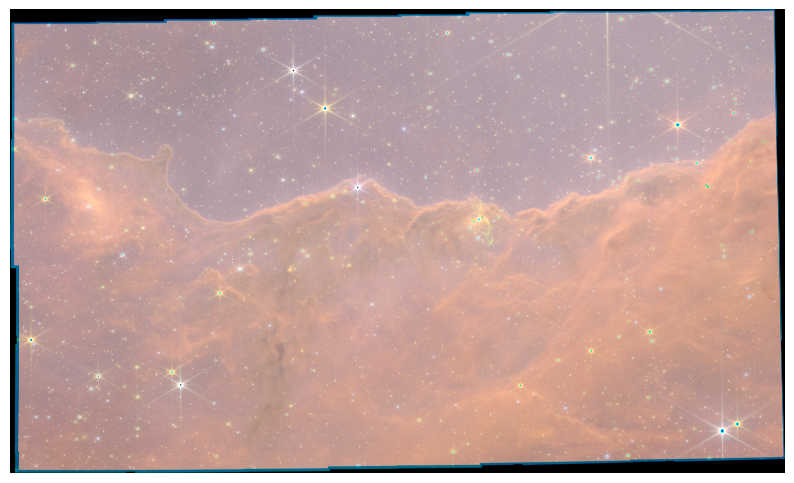

In [39]:
r = np.clip(data4 + 0.5 * data3, 0, 1)
g = np.clip(data2 + 0.5 * data5, 0, 1)
b = np.clip(data6 + 0.5 * data1, 0, 1)
print(r)
rgb = np.stack([r,g,b], axis = -1)

#Display the plot and save
plt.figure(figsize=(10,10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.axis()
# plt.savefig("ngc3324_false_color.png", dpi = 300, bbox_inches='tight')
plt.show()